In [1]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

##### Fetch Live stock data 

In [2]:
stock = yf.Ticker("CESC.NS")
data = stock.history(period="3y", interval="1d")

data.index = data.index.date  # converts to plain date (datetime.date object)
# Select only numerical columns and round to 2 decimal places
data = data.round(2)
# ṛemoving not needed columns from the data
data = data[["Close", "Open" , "Low" , "High" , "Volume"]]

In [3]:
print("Stock Price of last 5 days :::")
data.tail()

Stock Price of last 5 days :::


,Close,Open,Low,High,Volume
2025-08-21,164.72,163.99,163.60,165.20,1426608
2025-08-22,166.81,164.72,163.43,167.36,3529704
2025-08-25,164.24,167.60,163.90,168.35,1746429
2025-08-26,161.64,163.50,160.42,171.07,13455154
2025-08-28,154.17,161.70,153.10,162.10,7643737


##### Neccesary Data pre-processing steps 

In [4]:
# check for missing values
print("Missing values in data >>>\n")
data.isna().sum()

Missing values in data >>>



Close     0
Open      0
Low       0
High      0
Volume    0
dtype: int64

In [5]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe())

summary statistics  
             Close        Open         Low        High        Volume
count  741.000000  741.000000  741.000000  741.000000  7.410000e+02
mean   119.918704  120.070054  118.019609  122.109474  5.358856e+06
std     45.258767   45.349119   44.330745   46.281567  6.372577e+06
min     59.420000   59.660000   58.390000   61.260000  0.000000e+00
25%     69.920000   70.010000   69.220000   70.900000  2.032163e+06
50%    126.690000  126.940000  124.360000  129.360000  3.619410e+06
75%    163.720000  164.320000  161.780000  166.340000  6.155080e+06
max    202.320000  202.800000  196.700000  206.280000  7.028120e+07


##### Stock Price Visualization 

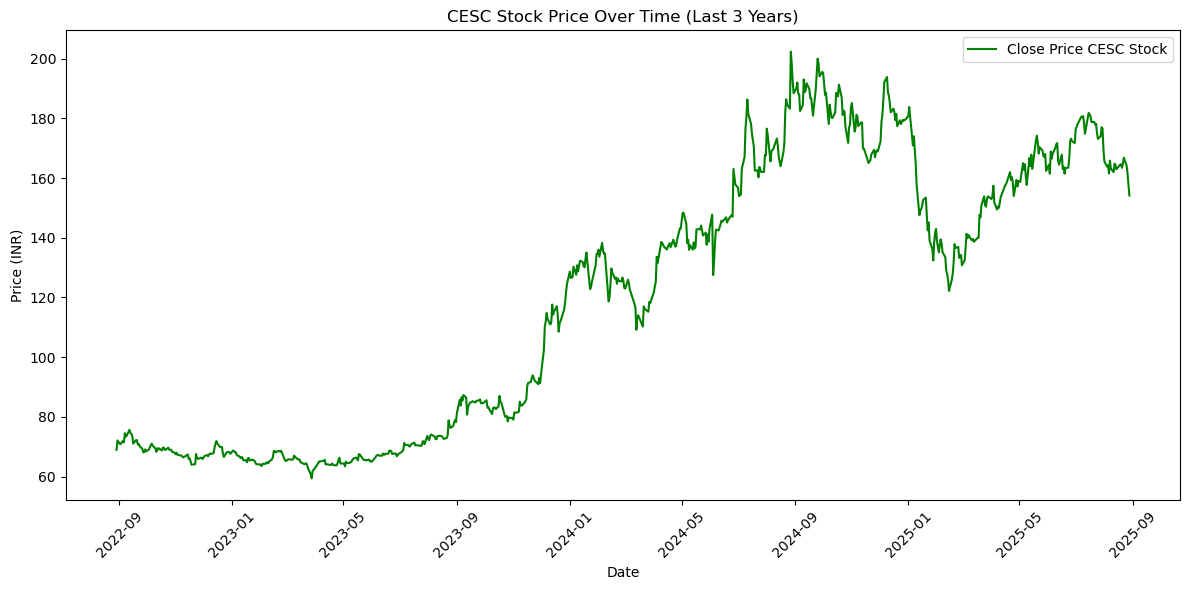

In [6]:
# stock price over the time using line chart
plt.figure(figsize=(12, 6))
sb.lineplot(data=data, x=data.index, y="Close", label="Close Price CESC Stock" , color="green")
plt.title("CESC Stock Price Over Time (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

##### Scatter plot shows the association between two variable (how much they're depended)

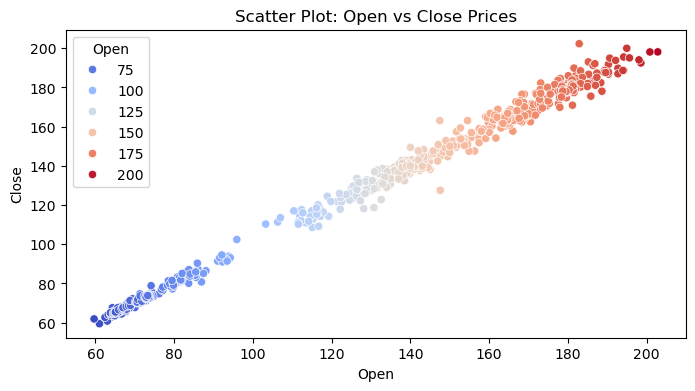

In [7]:
# Scatter plot between Open & Close prices
plt.figure(figsize=(8, 4))
sb.scatterplot(x=data['Open'], y=data['Close'], hue=data['Open'], palette='coolwarm')
plt.title("Scatter Plot: Open vs Close Prices")
plt.show()

##### Heatmap shows the correlations of all the numerical cols and shows how all are connected

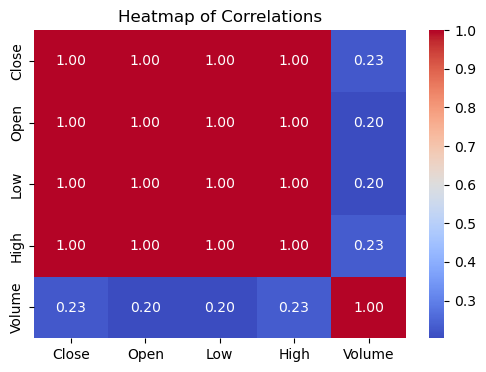

In [8]:
numeric_cols = data.select_dtypes(include=['float64', 'int64'])
# heatmap for visualizing relationships between numerical columns
plt.figure(figsize=(6, 4))
sb.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of Correlations")
plt.show()

###### Rule of thumb:-
- 0.5 < skew < 0.5 → fairly symmetrical
- Otherwise → consider transformation

In [9]:
print("Skewness (Close):", skew(data['Close']))
print("Skewness (Open):", skew(data['Open']))
print("Skewness (High):", skew(data['High']))
print("Skewness (Low):", skew(data['Low']))
print("Skewness (Volume):", skew(data['Volume']))

Skewness (Close): 0.05759403690809414
Skewness (Open): 0.06002114130446268
Skewness (High): 0.05209255121114081
Skewness (Low): 0.0704564717448643
Skewness (Volume): 4.633319907270452


#### Skewness Analysis 
- Close = 0.124 -> 	Almost symmetrical — no serious skew.
- Open = 0.127 -> 	Almost symmetrical — no serious skew.
- High = 0.118 -> 	Almost symmetrical — no serious skew.
- Low = 0.137 -> 	Almost symmetrical — no serious skew.
- Volume = 4.647 -> Highly positively skewed — heavy right tail (some days have extremely high volume compared to others).

In [10]:
# Volume:
# Extremely skewed — a few trading days have unusually high volumes.
# This can cause LSTM to overemphasize rare spikes.
# Solution : Log transformation to reduce skewness.

## As of now, we are not using volume in our model, but if we do, we can apply log transformation to reduce skewness in future. 

##### Including Other Features/Variables such as %change, EMA and so on

##### Daily % Change in close price

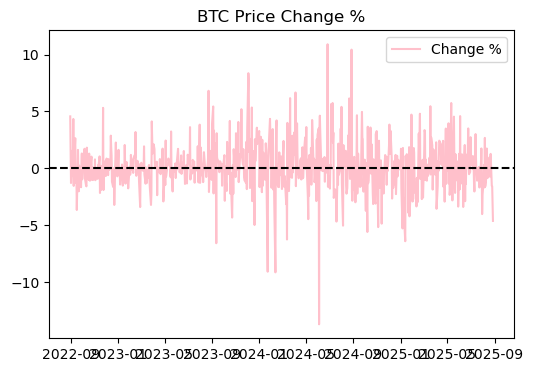

In [11]:
# price changes in %
data["change%"] =  data["Close"].pct_change() *100
# graph depicting the % change
plt.figure(figsize=(6,4))
plt.plot(data["change%"] , label="Change %" , color="pink")
plt.title("BTC Price Change %")
plt.axhline(y=0 , color="black" , linestyle="--")
plt.legend()
plt.show()

##### MA - Moving Averages

           2025-08-21    2025-08-22    2025-08-25    2025-08-26    2025-08-28
Close    1.647200e+02  1.668100e+02  1.642400e+02  1.616400e+02  1.541700e+02
Open     1.639900e+02  1.647200e+02  1.676000e+02  1.635000e+02  1.617000e+02
Low      1.636000e+02  1.634300e+02  1.639000e+02  1.604200e+02  1.531000e+02
High     1.652000e+02  1.673600e+02  1.683500e+02  1.710700e+02  1.621000e+02
Volume   1.426608e+06  3.529704e+06  1.746429e+06  1.345515e+07  7.643737e+06
change%  7.893288e-01  1.268820e+00 -1.540675e+00 -1.583049e+00 -4.621381e+00
MA7      1.641829e+02  1.644686e+02  1.644571e+02  1.642743e+02  1.628057e+02
MA30     1.710537e+02  1.706660e+02  1.703137e+02  1.696993e+02  1.687767e+02


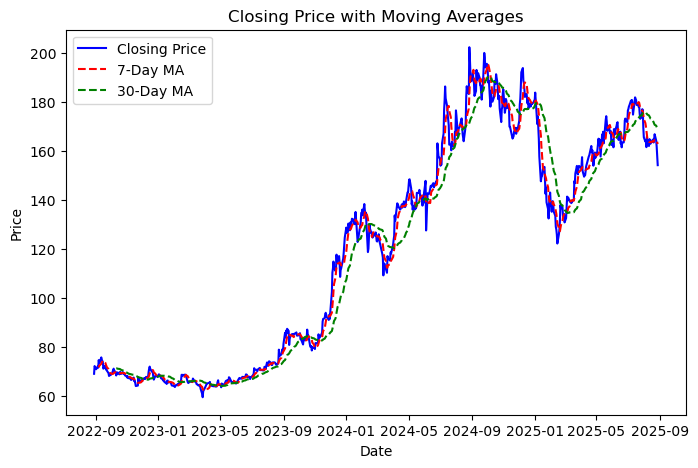

In [12]:
# calculate the moving average  > avg moving price over the time period
data["MA7"] = data["Close"].rolling(window=7).mean()
data["MA30"] = data["Close"].rolling(window=30).mean()

print(data.tail().T)

# Plot Closing Price with Moving Averages
plt.figure(figsize=(8, 5))
plt.plot( data["Close"], label="Closing Price", color='blue')
plt.plot(data["MA7"], label="7-Day MA", color='red', linestyle="dashed")
plt.plot( data["MA30"], label="30-Day MA", color='green', linestyle="dashed")
plt.title("Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


##### RSI - Relative Strength Index, ATR- Average True range and others

In [13]:
def compute_RSI(data, window=14):
    delta = data["Close"].diff() # Calculate daily price change (Close price today - yesterday).
    # If the change is positive ➔ Keep it, otherwise ➔ Set to 0. Then, take a moving average of gains over the past 14 days.
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean() 
    # If the change is negative ➔ Take the positive value of it (i.e., losses). Then, moving average of losses over 14 days.
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data["RSI_14"] = compute_RSI(data)

# Volatility: Standard Deviation of Close Price over 7-day window
data['Volatility_7'] = data['Close'].rolling(window=7).std()

# Average True Range (ATR) - Measures market volatility
data['ATR_14'] = (data['High'] - data['Low']).rolling(window=14).mean()

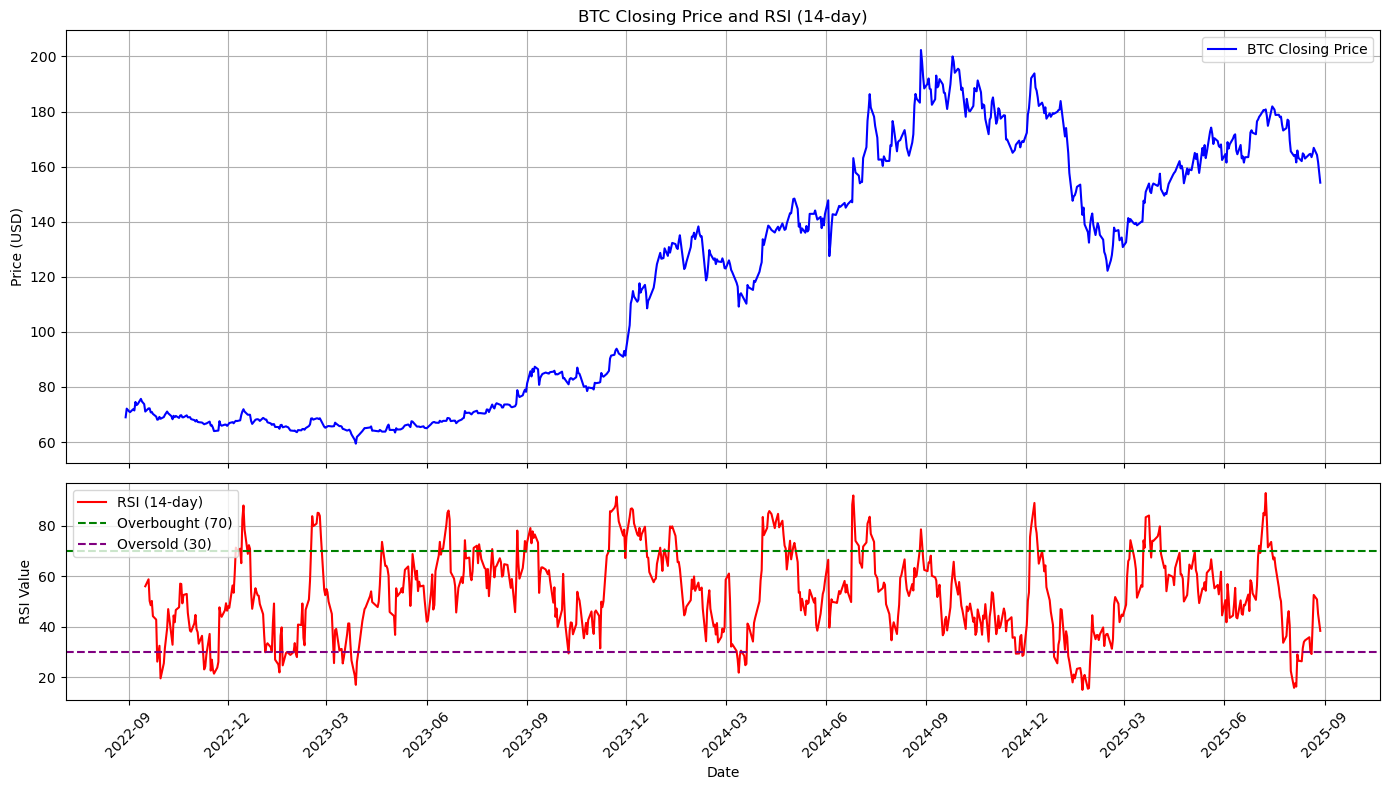

In [14]:
# Plot closing price and RSI in two subplots
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot closing price in the first subplot
ax[0].plot(data.index, data['Close'], color='blue', label='BTC Closing Price')
ax[0].set_title('BTC Closing Price and RSI (14-day)')
ax[0].set_ylabel('Price (USD)')
ax[0].legend()
ax[0].grid()

# Plot RSI in the second subplot
ax[1].plot(data.index, data['RSI_14'], color='red', label='RSI (14-day)')
ax[1].axhline(70, color='green', linestyle='--', label='Overbought (70)')
ax[1].axhline(30, color='purple', linestyle='--', label='Oversold (30)')
ax[1].set_ylabel('RSI Value')
ax[1].set_xlabel('Date')
ax[1].legend()
ax[1].grid()

# Format x-axis dates for better readability
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Other visualization 

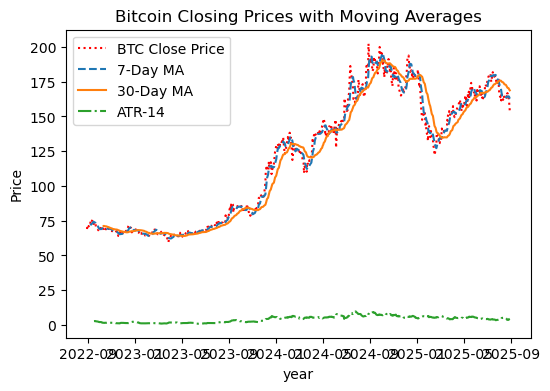

In [15]:
# visualize indicators
plt.figure(figsize=(6, 4))
plt.plot( data['Close'], label="BTC Close Price", color='red' , linestyle=":")
plt.plot(data['MA7'], label='7-Day MA', linestyle="--")
plt.plot(data['MA30'], label='30-Day MA', linestyle='-')
plt.plot(data["ATR_14"] , label="ATR-14" , linestyle="-.")
plt.title("Bitcoin Closing Prices with Moving Averages")
plt.xlabel("year")
plt.ylabel("Price")
plt.legend()
plt.show()

##### BB - Bollinger Bands

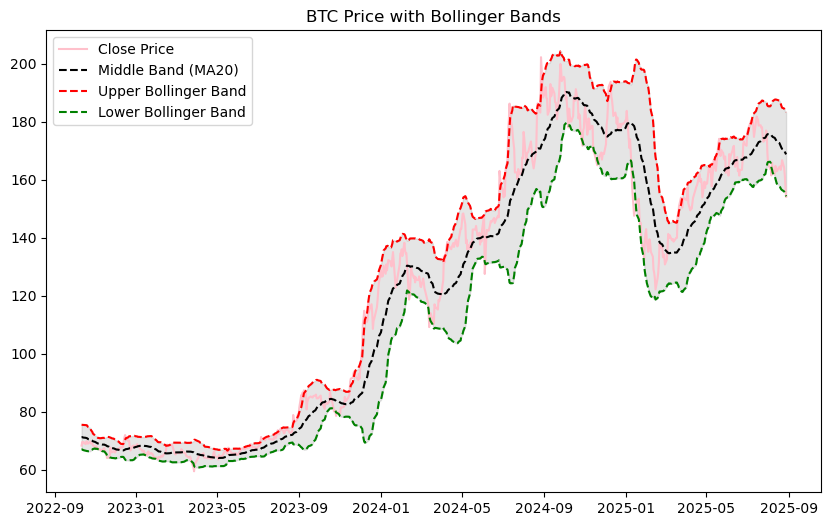

In [16]:
#middle band
data["MidBand"] = data["MA30"]
# calculate the std deviation for rolling window
data["Std_Deviation"] = data["Close"].rolling(window=30).std()
#lower and upper band
data["LowerBand"] = data["MidBand"] -( 2 * data["Std_Deviation"])
data["UpperBand"] = data["MidBand"] + ( 2 * data["Std_Deviation"])

# Drop NaN values (caused by rolling calculations)
data.dropna(inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label="Close Price", color='pink')
plt.plot(data.index, data['MidBand'], label="Middle Band (MA20)", color='black', linestyle='dashed')
plt.plot(data.index, data['UpperBand'], label="Upper Bollinger Band", color='red', linestyle='dashed')
plt.plot(data.index, data['LowerBand'], label="Lower Bollinger Band", color='green', linestyle='dashed')

plt.fill_between(data.index, data['LowerBand'], data['UpperBand'], color='gray', alpha=0.2)  # Shaded Bollinger area
plt.title("BTC Price with Bollinger Bands")
plt.legend()
plt.show()


In [17]:
## Adding a trend column to the data
# This column indicates whether the price is expected to go up (1) or down (0
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [18]:
print("Overview of dataset after adding some features \n\n")
data = data.round(2)  # rounding off the values for better readability
data.tail()

Overview of dataset after adding some features 




,Close,Open,Low,High,Volume,change%,MA7,MA30,RSI_14,Volatility_7,ATR_14,MidBand,Std_Deviation,LowerBand,UpperBand,Trend
2025-08-21,164.72,163.99,163.60,165.20,1426608,0.79,164.18,171.05,40.79,0.72,3.71,171.05,7.20,156.65,185.46,1
2025-08-22,166.81,164.72,163.43,167.36,3529704,1.27,164.47,170.67,52.65,1.23,3.64,170.67,7.10,156.46,184.87,0
2025-08-25,164.24,167.60,163.90,168.35,1746429,-1.54,164.46,170.31,50.88,1.23,3.65,170.31,7.15,156.01,184.62,0
2025-08-26,161.64,163.50,160.42,171.07,13455154,-1.58,164.27,169.70,45.15,1.55,4.09,169.70,7.08,155.54,183.86,0
2025-08-28,154.17,161.70,153.10,162.10,7643737,-4.62,162.81,168.78,38.45,4.11,4.43,168.78,7.24,154.29,183.26,0
